# M5 Forecasting Dataset EDA and Pre BI Processing

Medium articles  
* https://deshram.medium.com/forecasting-sales-of-items-in-retail-chains-b6e2f37cd99b 
* https://medium.com/analytics-vidhya/m5-forecasting-accuracy-time-series-forecasting-using-walmart-sales-data-374765d3f1f7

EDA Github Notebooks
* https://github.com/Deshram/M5-accuracy/blob/main/EDA_FE.ipynb
* https://github.com/aakashveera/M5-Accuracy/blob/master/Notebook%20M5%20Accuracy.ipynb


Enhancements and Changes to the Git nobebooks above
  * The notebook has been cleaned up to work with matplotlib, sns, and other fixes 
  * Merging some techniques from the above two notebooks
  * Some additional analysis (sell price variability)
  * Purpose of this notebook is to explore the data and pre-process for BI
  * The data is reformatted for BI dashboard analysis ... 
  * DIM and FACT tables for star schema model significantly reduce the file footprint from a one large table ~ 8 GB file size. The two largest tales Sales is ~600 MB and Prices ~260 MB. This is now setup for a OLAP style processor to do the DIM and FACT combining. 
  * Later we can combine into one fat table for AI and forecasting models..
  * Index by date and let the BI do the date aggregations instead of each one being a one off
  * State and Store Id will be dimensions tables in Power BI
  * Note, will create a Date Dimension table in Power BI so definitely do not try and create date dimensions here.
  
Comments for future enhancment
  * Google Trends
  * State/Local Demographics
  * Weather
  * CPI
  * date_part for improved forecasting as in Fast.ai

BI Output Files

* ItemDeptCat.csv
* StoreState.csv
* Sales.csv
* cal_events_detail.csv
* cal_events_summar.csv


Source: https://www.kaggle.com/c/m5-forecasting-accuracy/overview

<b>Problem Statement</b>: Using hierarchical sales data from Walmart, the world’s largest company by revenue, to forecast daily sales for the next 28 days. As these forecasting may lead to provide supply of right product at right store at right time, keeping balance in inventory levels and this can lead to increase in revenue. 

**Walmart Hierarchical sales data**, the world’s largest company by revenue, to forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy.

The dataset, covers the sales of stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events.

**Performance metric**  
The accuracy of the point forecasts will be evaluated using the Root Mean Squared Scaled Error (RMSSE), which is a variant of the well-known Mean Absolute Scaled Error (MASE).The measure is calculated for each series as follows:image.

The measure is scale independent, meaning that it can be effectively used to compare forecasts across series with different scales.
The measure penalizes positive and negative forecast errors, as well as large and small forecasts, equally, thus being symmetric.

# Initialize the Notebook

In [1]:
import pandas as pd
import numpy as np
#from downcast import reduce
import matplotlib.pyplot as plt
import seaborn as sns
%run plot_helper_functions # download these from github

In [2]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns', None)

# Load Data

* Calendar.csv: It contains the information about the dates on which the products are sold and the events and programs that held on that day.
* Sales_train_evaluation: historical daily unit sales of each product on each store from day 1 to day 1941.
* Sell_prices: information about the price of the products on each week per store.
* SNAP is a nutritional assistance program conducted on US through which low income families can purchase food on that specific date. It is a binary feature representing whether snap held or not on the specific date on each state.
* Price of products were not constant and the price of products on each week is provided.

In [3]:
data_path = 'data_m5'
sales = pd.read_csv(f'{data_path}/sales_train_validation.csv')
prices = pd.read_csv(f'{data_path}/sell_prices.csv')
cal = pd.read_csv(f'{data_path}/calendar.csv')

print("Shape of sales:",sales.shape)
print("Shape of prices:",prices.shape)
print("Shape of cal:",cal.shape)


Shape of sales: (30490, 1919)
Shape of prices: (6841121, 4)
Shape of cal: (1969, 14)


In [4]:
sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [5]:
prices.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [6]:
cal.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

# Stores, Categories, and Departments, and Products

Ten stores, each store caries 3049 items

In [7]:
# Unique Stores and unique products
sales.groupby(['store_id'])['item_id'].nunique()

store_id
CA_1    3049
CA_2    3049
CA_3    3049
CA_4    3049
TX_1    3049
TX_2    3049
TX_3    3049
WI_1    3049
WI_2    3049
WI_3    3049
Name: item_id, dtype: int64

Stores, categories and departments
* 10 storse: 4 CA, 3 TX, 3 WI
* 3 store categories  within each store: FOODS, HOBBIES, HOUSEHOLDS
* Store categories with departments
   * FOODS - FOODS_1, FOODS_2, FOODS_3, 
   * HOBBIES - HOBBIES_1, HOBBIES_2
   * HOUSEHOLD - HOUSEHOLD_1, HOUSEHOLD_2

In [8]:
# Unique products per store ... over 3K unique items per store
display(sales.groupby(['store_id', 'cat_id','dept_id'])['item_id'].nunique() )

store_id  cat_id     dept_id    
CA_1      FOODS      FOODS_1        216
                     FOODS_2        398
                     FOODS_3        823
          HOBBIES    HOBBIES_1      416
                     HOBBIES_2      149
          HOUSEHOLD  HOUSEHOLD_1    532
                     HOUSEHOLD_2    515
CA_2      FOODS      FOODS_1        216
                     FOODS_2        398
                     FOODS_3        823
          HOBBIES    HOBBIES_1      416
                     HOBBIES_2      149
          HOUSEHOLD  HOUSEHOLD_1    532
                     HOUSEHOLD_2    515
CA_3      FOODS      FOODS_1        216
                     FOODS_2        398
                     FOODS_3        823
          HOBBIES    HOBBIES_1      416
                     HOBBIES_2      149
          HOUSEHOLD  HOUSEHOLD_1    532
                     HOUSEHOLD_2    515
CA_4      FOODS      FOODS_1        216
                     FOODS_2        398
                     FOODS_3        823
       

# Merge Sales, Price, and Cal

In [9]:
sales.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   


In [10]:
# Melting the data from wide form to long form
# i.e. converting all sales at date columns to row, for each row getting sales at that date
#for better understanding compare the above dataframe and below dataframe

print('data = melt sales  ... ',end='')
print(sales.shape)
data = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='unit_sales')

print(f'data.shape = {data.shape}')
display(data.head())

print('merge with cal ...')
data = pd.merge(data, cal, on='d', how='left')
display(data.head())

print('marge with prices ...')
data = pd.merge(data, prices, on=['store_id','item_id','wm_yr_wk'], how='left')
data['revenue'] = data['unit_sales']* data['sell_price']
display(data.head())

data = melt sales  ... (30490, 1919)
data.shape = (58327370, 8)


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  unit_sales  
0       CA  d_1           0  
1       CA  d_1           0  
2       CA  d_1           0  
3       CA  d_1           0  
4       CA  d_1           0

merge with cal ...


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  unit_sales        date  wm_yr_wk   weekday  wday  month  \
0       CA  d_1           0  2011-01-29     11101  Saturday     1      1   
1       CA  d_1           0  2011-01-29     11101  Saturday     1      1   
2       CA  d_1           0  2011-01-29     11101  Saturday     1      1   
3       CA  d_1           0  2011-01-29     11101  Saturday     1      1   
4       CA  d_1           0  2011-01-29     11101  Saturday     1      1   

   year event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  \
0  2011          NaN          NaN          NaN          NaN        0        0   
1  2011          NaN          NaN          NaN          NaN        0        0   
2  2011          NaN          NaN          NaN          NaN        0        0   
3  2011          NaN          NaN          NaN          NaN        0        0   
4  2011          NaN          NaN          NaN          NaN        0        0   

   snap_WI  
0        0  
1        0  
2        0  
3        0  
4        0

marge with prices ...


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  unit_sales        date  wm_yr_wk   weekday  wday  month  \
0       CA  d_1           0  2011-01-29     11101  Saturday     1      1   
1       CA  d_1           0  2011-01-29     11101  Saturday     1      1   
2       CA  d_1           0  2011-01-29     11101  Saturday     1      1   
3       CA  d_1           0  2011-01-29     11101  Saturday     1      1   
4       CA  d_1           0  2011-01-29     11101  Saturday     1      1   

   year event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  \
0  2011          NaN          NaN          NaN          NaN        0        0   
1  2011          NaN          NaN          NaN          NaN        0        0   
2  2011          NaN          NaN          NaN          NaN        0        0   
3  2011          NaN          NaN          NaN          NaN        0        0   
4  2011          NaN          NaN          NaN          NaN        0        0   

   snap_WI  sell_price  revenue  
0        0         NaN      NaN  
1        0         NaN      NaN  
2        0         NaN      NaN  
3        0         NaN      NaN  
4        0         NaN      NaN

In [45]:
## Save the merged table just to see how big it is

#data.to_csv('./data_m5/data_merged.csv',index = False)

In [11]:
# https://deallen7.medium.com/managing-date-datetime-and-timestamp-in-python-pandas-cc9d285302ab
# normalize removes the time element (00:00:00)
data['date']=pd.to_datetime(data['date'])
data['date']=data['date'].dt.normalize()  
print('yearweek ...')
data['week']=data['date'].dt.week #.astype('int16')
data['yearweek']= data['year']*100+data['week']  #.astype('int64')
print('yearmonth ...')
data['yearmonth'] = data['year']*100 + data['month'] # .astype('int64')
data.head()

yearweek ...
yearmonth ...


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id    d  unit_sales       date  wm_yr_wk   weekday  wday  month  year  \
0       CA  d_1           0 2011-01-29     11101  Saturday     1      1  2011   
1       CA  d_1           0 2011-01-29     11101  Saturday     1      1  2011   
2       CA  d_1           0 2011-01-29     11101  Saturday     1      1  2011   
3       CA  d_1           0 2011-01-29     11101  Saturday     1      1  2011   
4       CA  d_1           0 2011-01-29     11101  Saturday     1      1  2011   

  event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  \
0          NaN          NaN          NaN          NaN        0        0   
1          NaN          NaN          NaN          NaN        0        0   
2          NaN          NaN          NaN          NaN        0        0   
3          NaN          NaN          NaN          NaN        0        0   
4          NaN          NaN          NaN          NaN        0        0   

   snap_WI  sell_price  revenue  week  yearweek  yearmonth  
0        0         NaN      NaN     4    201104     201101  
1        0         NaN      NaN     4    201104     201101  
2        0         NaN      NaN     4    201104     201101  
3        0         NaN      NaN     4    201104     201101  
4        0         NaN      NaN     4    201104     201101

# Unit demand by Item

* Sell prices change over time  ... each week, let's take a look
* Some variability of prices by store and state

In [12]:

timeframe='yearweek'
store_sell_prices=data.groupby([timeframe,'store_id','item_id'])['sell_price'].mean()
display(store_sell_prices.head())
y=store_sell_prices.loc[(slice(':'),slice('CA_1'),slice('FOODS_1_001'))].values  # example slice the index
store_sell_prices=store_sell_prices.reset_index()
display(store_sell_prices.head())



yearweek  store_id  item_id    
201104    CA_1      FOODS_1_001    2.00
                    FOODS_1_002    7.88
                    FOODS_1_003    2.88
                    FOODS_1_004     NaN
                    FOODS_1_005    2.94
Name: sell_price, dtype: float64

yearweek store_id      item_id  sell_price
0    201104     CA_1  FOODS_1_001        2.00
1    201104     CA_1  FOODS_1_002        7.88
2    201104     CA_1  FOODS_1_003        2.88
3    201104     CA_1  FOODS_1_004         NaN
4    201104     CA_1  FOODS_1_005        2.94

### Explore price

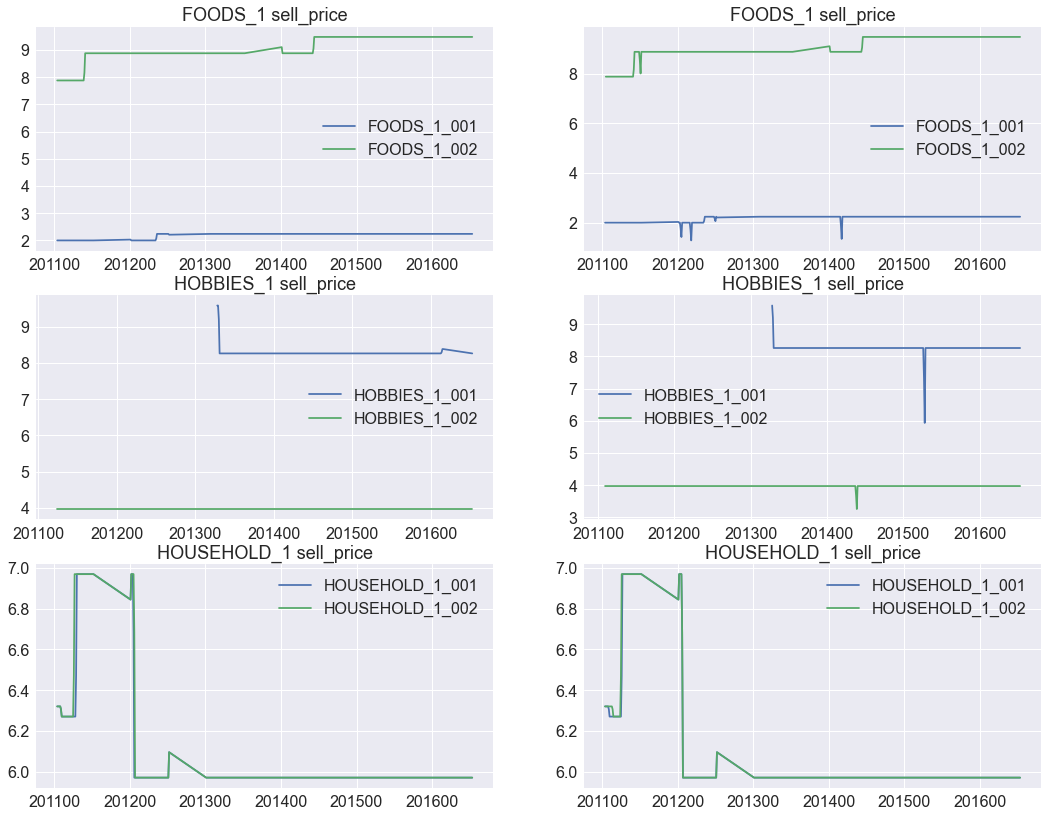

In [13]:

plot_options=get_plot_defaults()
plt.style.use(plot_options['pltstyle']) # defaults to seaborn
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(18,14))

#CA_1
## FOODS
ax_n=ax[0,0]
store ='CA_1'
item = 'FOODS_1_001'
x=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ][timeframe]
y=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ]['sell_price']
ax_n.plot(x,y,label = item)


store ='CA_1'
item = 'FOODS_1_002'
x=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ][timeframe]
y=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ]['sell_price']
ax_n.plot(x,y,label = item)


plot_options.update({'title':'FOODS_1 sell_price'})
plot_options.update({'legend':True})
set_axisparams(plot_options,ax_n) # set the axis parameters >> nicer than matplotlib defaults


## HOBBIES
ax_n=ax[1,0]

store ='CA_1'
item = 'HOBBIES_1_001'
x=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ][timeframe]
y=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ]['sell_price']
ax_n.plot(x,y,label = item)


store ='CA_1'
item = 'HOBBIES_1_002'
x=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ][timeframe]
y=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ]['sell_price']
ax_n.plot(x,y,label = item)


plot_options.update({'title':'HOBBIES_1 sell_price'})
plot_options.update({'legend':True})
set_axisparams(plot_options,ax_n) # set the axis parameters >> nicer than matplotlib defaults

## HOUSEHOLD
ax_n=ax[2,0]
store ='CA_1'
item = 'HOUSEHOLD_1_001'
x=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ][timeframe]
y=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ]['sell_price']
ax_n.plot(x,y,label = item)


store ='CA_1'
item = 'HOUSEHOLD_1_002'
x=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ][timeframe]
y=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ]['sell_price']
ax_n.plot(x,y,label = item)


plot_options.update({'title':'HOUSEHOLD_1 sell_price'})
plot_options.update({'legend':True})
set_axisparams(plot_options,ax_n) # set the axis parameters >> nicer than matplotlib defaults


# TX_1
## FOODS
ax_n=ax[0,1]
store ='TX_1'
item = 'FOODS_1_001'
x=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ][timeframe]
y=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ]['sell_price']
ax_n.plot(x,y,label = item)


store ='TX_1'
item = 'FOODS_1_002'
x=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ][timeframe]
y=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ]['sell_price']
ax_n.plot(x,y,label = item)


plot_options.update({'title':'FOODS_1 sell_price'})
plot_options.update({'legend':True})
set_axisparams(plot_options,ax_n) # set the axis parameters >> nicer than matplotlib defaults


## HOBBIES
ax_n=ax[1,1]

store ='TX_1'
item = 'HOBBIES_1_001'
x=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ][timeframe]
y=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ]['sell_price']
ax_n.plot(x,y,label = item)


store ='TX_1'
item = 'HOBBIES_1_002'
x=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ][timeframe]
y=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ]['sell_price']
ax_n.plot(x,y,label = item)


plot_options.update({'title':'HOBBIES_1 sell_price'})
plot_options.update({'legend':True})
set_axisparams(plot_options,ax_n) # set the axis parameters >> nicer than matplotlib defaults

## HOUSEHOLD
ax_n=ax[2,1]
store ='TX_1'
item = 'HOUSEHOLD_1_001'
x=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ][timeframe]
y=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ]['sell_price']
ax_n.plot(x,y,label = item)


store ='TX_1'
item = 'HOUSEHOLD_1_002'
x=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ][timeframe]
y=store_sell_prices[ (store_sell_prices['store_id']==store ) &   (store_sell_prices['item_id']==item ) ]['sell_price']
ax_n.plot(x,y,label = item)


plot_options.update({'title':'HOUSEHOLD_1 sell_price'})
plot_options.update({'legend':True})
set_axisparams(plot_options,ax_n) # set the axis parameters >> nicer than matplotlib defaults


# Unit Sales (demand)

total sales over all departments and stores


date  sales
0 2011-01-29  32631
1 2011-01-30  31749
2 2011-01-31  23783
3 2011-02-01  25412
4 2011-02-02  19146

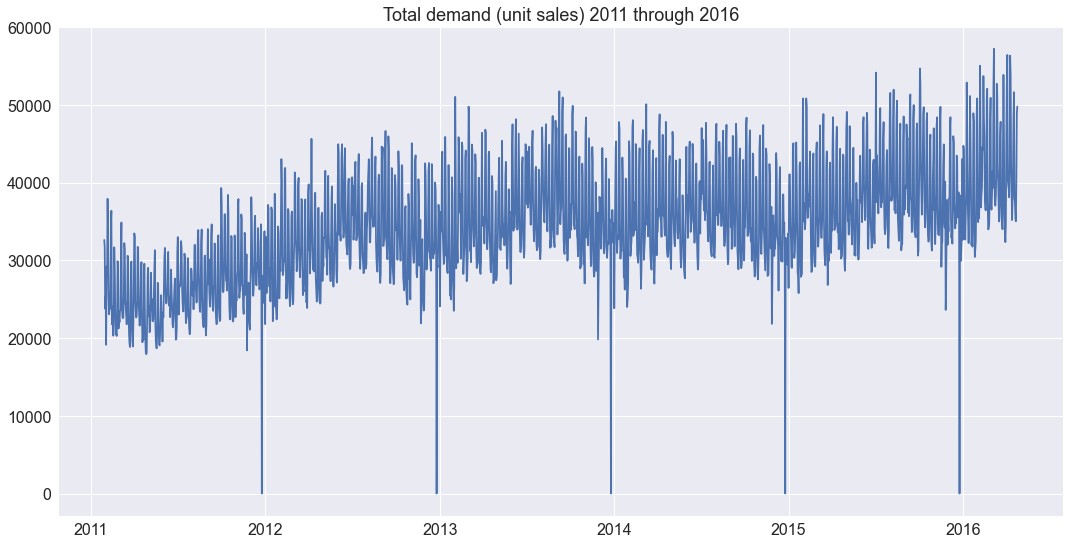

In [15]:
d_cols = [i for i in sales.columns if 'd_' in i] # d_ day numbers
sales_df = sales[d_cols]
total_sales = list(sales_df.sum(axis = 0)) # sum department sales by day ... one entry per day

dates = [d for d in pd.date_range(start = '2011-01-29', end = '2016-04-24')]
agg_sales = pd.DataFrame({'date' : dates,'sales' : total_sales})
print('total sales over all departments and stores')
display(agg_sales.head())


plot_options=get_plot_defaults() # get default options
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9))
x=agg_sales['date']
y=agg_sales['sales']
ax.plot(x,y)
plot_options.update({'title':'Total demand (unit sales) 2011 through 2016'})
set_axisparams(plot_options,ax) # set the axis parameters >> nicer than matplotlib defaults

plt.show()


Observations:  
* After some decline in sales in 2011 an upward trend is observed  ... ALG there is a downward trend at the end of every year. It seems cyclic.
* Zero sales is observed in each year that is christmas (2011-12-25).
* After Zooming, a weekly seasonality is also observed.
* Comparing to all years, little faster growth is observed in 2016.

In [16]:
sales_df = sales.groupby(['state_id'])[d_cols].sum()

# month index
months = [(d.year*100)+d.month for d in pd.date_range(start = '2011-01-29', end = '2016-04-24')]


print('sales by state, by department')
display(sales_df.head())

print('CA sales by day')
display(sales_df.iloc[0].head())

agg_sales = pd.DataFrame({'date' : months, 'CA_sales' : sales_df.iloc[0], 'TX_sales' : sales_df.iloc[1], 'WI_sales' : sales_df.iloc[2]})
print('agg_sales by month ')
display(agg_sales.head())

monthly_sales = agg_sales.groupby('date').sum()  # month index, state columns
monthly_dates = [d for d in pd.date_range(start = '2011-01-29', end = '2016-04-24', freq = 'MS')]
display(monthly_sales.head())



sales by state, by department


d_1    d_2    d_3    d_4   d_5    d_6    d_7    d_8    d_9   d_10  \
state_id                                                                        
CA        14195  13805  10108  11047  9925  11322  12251  16610  14696  11822   
TX         9438   9630   6778   7381  5912   9006   6226   9440   9376   7319   
WI         8998   8314   6897   6984  3309   8883   9533  11882   8664   6431   

           d_11   d_12   d_13   d_14   d_15   d_16  d_17  d_18  d_19  d_20  \
state_id                                                                     
CA        10933  10350  11204  11354  14610  15630  9044  9496  8844  7835   
TX         6224   6740   6109   7202  10081  11725  6719  7460  6606  6412   
WI         5914   6568   6443   7889  10142   9025  6041  7114  5993  6071   

           d_21   d_22   d_23   d_24  d_25  d_26  d_27  d_28   d_29   d_30  \
state_id                                                                     
CA        10025  13870  13465  11997  9130  8941  8514  9847  13652  12491   
TX         6711   9150   9789   7297  6628  5814  6175  6286   8586   9086   
WI         6985   8669   6029   4672  4743  6002  5588  6396   7670   7130   

          d_31  d_32  d_33  d_34   d_35   d_36   d_37   d_38   d_39  d_40  \
state_id                                                                    
CA        9196  9782  9537  9710  10444  13784  16057  10953  10299  9951   
TX        6555  7082  6145  6639   6584   9238  10423   7623   6335  6941   
WI        5489  6008  6364  7126   6544   8180   8396   5986   6118  5668   

           d_41   d_42   d_43   d_44   d_45  d_46  d_47  d_48   d_49   d_50  \
state_id                                                                      
CA        10012  11189  13710  14340  10722  9293  9752  9504  10030  14509   
TX         6339   7203   9271   9542   7745  7834  6768  6759   7131   8203   
WI         6275   7180   9244   7535   6468  6894  6245  5516   6694   7887   

           d_51   d_52  d_53  d_54  d_55   d_56   d_57   d_58  d_59  d_60  \
state_id                                                                    
CA        14112  10255  9383  8490  7889  11011  13816  13661  9997  8516   
TX         8992   7075  6086  5914  5898   6249   8072   9434  6429  5728   
WI         6539   5771  5023  4826  5067   6090   7732   6771  5023  5337   

          d_61   d_62   d_63   d_64   d_65   d_66   d_67   d_68   d_69   d_70  \
state_id                                                                        
CA        8911  10059  12827  14791  15341  12356  10497  10101  10575  10971   
TX        5384   6096   7992   9134   9863   6648   6743   6689   7201   6797   
WI        4633   5587   7490   9553   7854   5848   6341   5866   5125   6986   

           d_71   d_72   d_73  d_74  d_75  d_76   d_77   d_78   d_79  d_80  \
state_id                                                                     
CA        14064  15291  11098  9181  8853  9430  10922  12809  13894  9955   
TX         9025   9648   7555  7302  7202  6338   7749   8573   9248  7218   
WI         8656   6597   6176  6735  5556  6196   6811   7852   6645  5216   

          d_81  d_82  d_83   d_84   d_85   d_86  d_87  d_88  d_89  d_90  d_91  \
state_id                                                                        
CA        8930  8582  8986  10967  13577  11721  8865  8176  8135  7951  9730   
TX        6133  6387  5677   7542   8833   7897  6339  5535  5369  5372  6432   
WI        4411  5219  5105   5770   7165   4400  4800  4402  4425  4822  6573   

           d_92   d_93   d_94   d_95  d_96  d_97   d_98   d_99  d_100  d_101  \
state_id                                                                       
CA        12428  12997  10657  10669  9596  9281  10617  12386  11231  11264   
TX         8240   9644   6125   6937  5771  6372   7924   8863   7440   8001   
WI         7433   6404   6055   6474  5394  5531   5945   7163   5017   5759   

          d_102  d_103  d_104  d_105  d_106  d_107  

CA sales by day


d_1    14195
d_2    13805
d_3    10108
d_4    11047
d_5     9925
Name: CA, dtype: int64

agg_sales by month 


date  CA_sales  TX_sales  WI_sales
d_1  201101     14195      9438      8998
d_2  201101     13805      9630      8314
d_3  201101     10108      6778      6897
d_4  201102     11047      7381      6984
d_5  201102      9925      5912      3309

CA_sales  TX_sales  WI_sales
date                                
201101     38108     25846     24209
201102    318101    212015    196259
201103    339678    225162    198727
201104    331004    220681    186028
201105    321566    221620    176376

#### Monthly unit sales

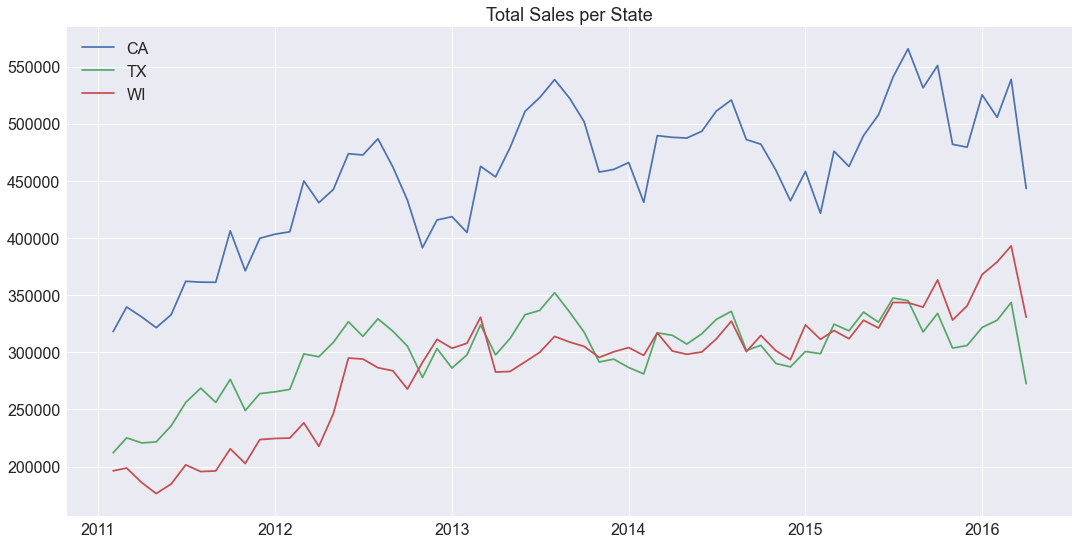

In [17]:
plot_options=get_plot_defaults()
plt.style.use(plot_options['pltstyle']) # defaults to seaborn
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9))


x=monthly_dates
y=monthly_sales.iloc[1:]['CA_sales']
ax.plot(x,y, label='CA')
y=monthly_sales.iloc[1:]['TX_sales']
ax.plot(x,y, label='TX')
y=monthly_sales.iloc[1:]['WI_sales']
ax.plot(x,y, label='WI')

plot_options.update({'title':"Total Sales per State"})
plot_options.update({'legend':True})
set_axisparams(plot_options,ax) 
ax.legend(prop={'size': 16})
plt.show()

### Observations:
* Comparing to other states California(CA) sales performed better, while sales of Texas(TX) and Wisconsin(WI) found to be intersecting with each other, ending up with a raise in Wisconsin(WI).  
* ... ALG: California has some form of cycles occuring. It may be worthwhile investigating
* Mostly the raise in sales in a year was observed in pre-Autumn months (Aug-Oct)
* In 2014-15 a dip was observed in sales, which was severe in CA and slightly less in other two.

#### Unit Sales per Store

store sales by day


d_1   d_2   d_3   d_4   d_5   d_6   d_7   d_8   d_9  d_10  d_11  \
store_id                                                                     
CA_1      4337  4155  2816  3051  2630  3276  3450  5437  4340  3157  2995   
CA_2      3494  3046  2121  2324  1942  2288  2629  3729  2957  2218  2123   
CA_3      4739  4827  3785  4232  3817  4369  4703  5456  5581  4912  4447   
CA_4      1625  1777  1386  1440  1536  1389  1469  1988  1818  1535  1368   
TX_1      2556  2687  1822  2258  1694  2734  1691  2820  2887  2174  1607   
TX_2      3852  3937  2731  2954  2492  3439  2588  3772  3657  2932  2628   
TX_3      3030  3006  2225  2169  1726  2833  1947  2848  2832  2213  1989   
WI_1      2704  2194  1562  1251     2  2049  2815  3248  1674  1355  1335   
WI_2      2256  1922  2018  2522  1175  2244  2232  2643  2140  1836  1526   
WI_3      4038  4198  3317  3211  2132  4590  4486  5991  4850  3240  3053   

          d_12  d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  \
store_id                                                                     
CA_1      2710  2928  3078  4316  4354  2757  2430  2272  2009  3015  4553   
CA_2      1901  2436  2584  3455  3563  1801  1797  1741  1614  2214  3080   
CA_3      4544  4406  4380  5187  5780  3303  3758  3641  3099  3320  4694   
CA_4      1195  1434  1312  1652  1933  1183  1511  1190  1113  1476  1543   
TX_1      2149  1895  2256  2944  3432  1921  2217  1962  1821  1951  2571   
TX_2      2669  2515  2883  4000  4779  2679  2927  2606  2449  2615  3705   
TX_3      1922  1699  2063  3137  3514  2119  2316  2038  2142  2145  2874   
WI_1      1410  1349  1946  2634  2012  1522  1363  1300  1459  1872  2596   
WI_2      1846  1785  2015  2442  2336  1612  1980  1628  1678  1813  2014   
WI_3      3312  3309  3928  5066  4677  2907  3771  3065  2934  3300  4059   

          d_23  d_24  d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  \
store_id                                                                     
CA_1      3966  3264  2441  2377  2414  2701  3719  3548  2246  2549  2559   
CA_2      3087  2601  1810  1851  1652  2187  3516  2692  1894  1958  1837   
CA_3      4794  4631  3593  3342  3310  3575  4774  4540  3604  3846  3821   
CA_4      1618  1501  1286  1371  1138  1384  1643  1711  1452  1429  1320   
TX_1      2810  2071  1933  1723  1825  1886  2629  2688  1985  1967  1860   
TX_2      3845  3006  2725  2268  2488  2506  3565  3660  2548  3023  2383   
TX_3      3134  2220  1970  1823  1862  1894  2392  2738  2022  2092  1902   
WI_1      1415   939  1089  1413  1449  1830  2154  1784  1327  1352  1279   
WI_2      1592  1356  1330  1719  1571  1532  1961  1643  1537  1667  1735   
WI_3      3022  2377  2324  2870  2568  3034  3555  3703  2625  2989  3350   

          d_34  d_35  d_36  d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  \
store_id                                                                     
CA_1      2568  2978  4096  4832  3138  2997  2772  2650  3249  4114  4094   
CA_2      2010  2105  3199  3272  1970  1800  2064  2041  2375  3114  3224   
CA_3      3757  3904  4894  5895  4274  4084  3754  3898  4108  4823  5342   
CA_4      1375  1457  1595  2058  1571  1418  1361  1423  1457  1659  1680   
TX_1      2052  1753  2642  3031  2272  1788  2180  1779  2073  2800  2737   
TX_2      2545  2718  3627  4379  2954  2495  2705  2613  2968  3704  3869   
TX_3      2042  2113  2969  3013  2397  2052  2056  1947  2162  2767  2936   
WI_1      1338  1560  1867  1996  1453  1359  1157  1521  1897  2351  1847   
WI_2      1946  1659  1967  1894  1635  1691  1480  1514  1699  2480  1935   
WI_3      3842  3325  4346  4506  2898  3068  3031  3240  3584  4413  3753   

          d_45  d_46  d_47  d_48  d_49  d_50  d_51  d_52  d_53  d_54  d_55  \
store_id                                                                     
CA_1      2880  2384  2522  2435  2744  4142  3904  2635  2458  2079  2281   
CA_2      2044  1969  2082  2

store_sales total


store_id
CA_1     7.698216
CA_2     5.685475
CA_3    11.188180
CA_4     4.103676
TX_1     5.595292
TX_2     7.214384
TX_3     6.089330
WI_1     5.149062
WI_2     6.544012
WI_3     6.427782
dtype: float64

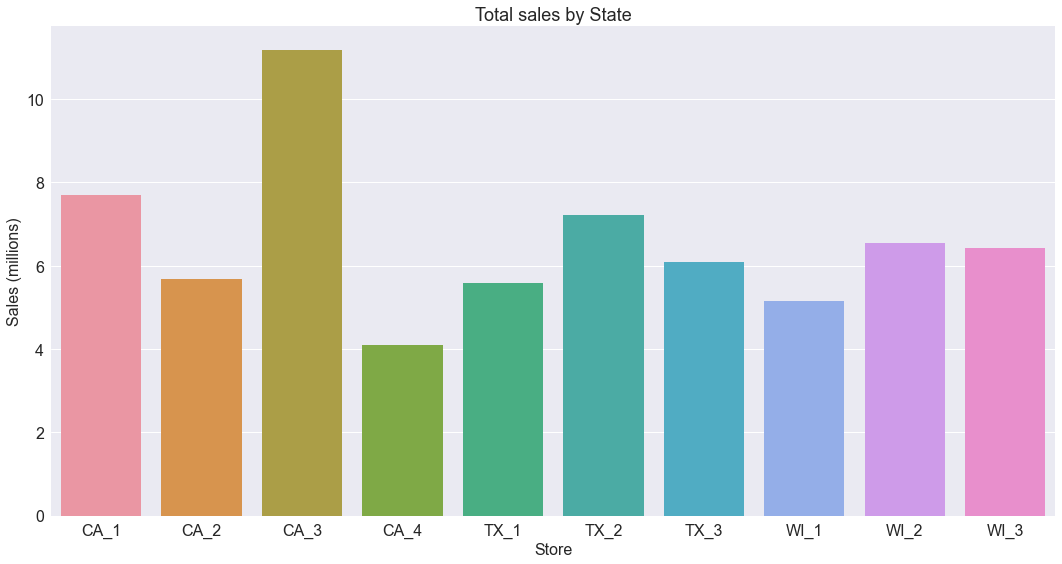

In [18]:
d_cols = [i for i in sales.columns if 'd_' in i]
sales_df = sales.groupby(['store_id'])[d_cols].sum()
print('store sales by day')
display(sales_df)
store_sales = sales_df.sum(axis = 1) # sum each row to get the total sales per store
store_sales = store_sales / 1e6 # normalize to millions
print('store_sales total')
display(store_sales)

bar_plot = pd.DataFrame({'stores':store_sales.index, 'sales':store_sales.values})
plot_options=get_plot_defaults()
plt.style.use(plot_options['pltstyle']) # defaults to seaborn
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9))

x=store_sales.index
y=store_sales.values
sns.barplot(x=x, y=y, ax=ax)
plot_options.update({'title':'Total sales by State'})
plot_options.update({'xlabel':'Store'})
plot_options.update({'ylabel':'Sales (millions)'})
set_axisparams(plot_options,ax) 
plt.show()


### Observations:
* The CA_3 store have the highest sales whereas CA_4 have the lowest
* Stores in Texas(TX) and Winsconsin(WI) have similar sales among their corresponding state stores.

# Category Unit Sales
* seasonal and trend

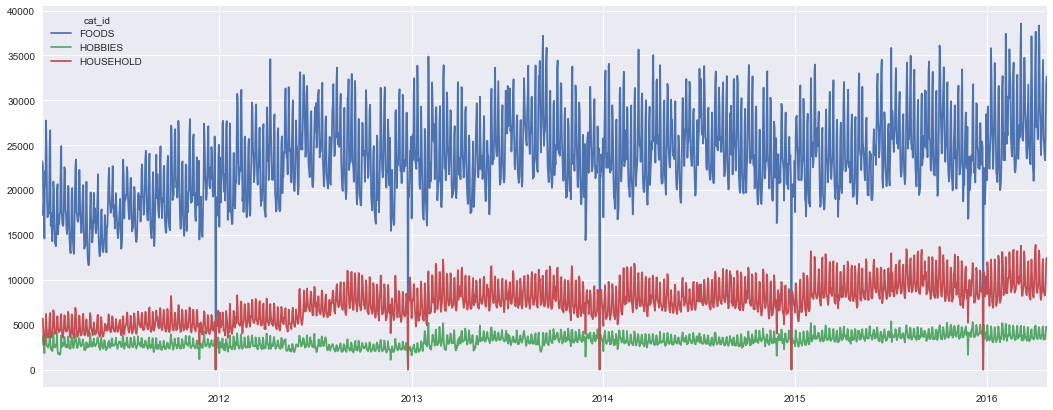

In [19]:

cat_agg =sales.drop(['id','item_id','dept_id','store_id','state_id'],axis=1).groupby('cat_id').sum()
cat_agg.columns=dates
cat_agg.transpose().plot(figsize=(18,7));

# Store Unit Sales

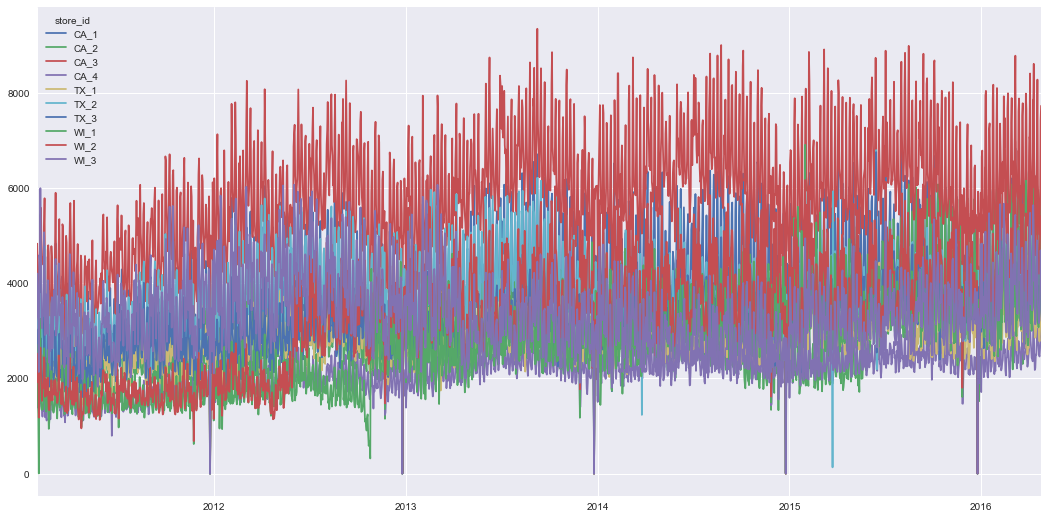

In [20]:
store_agg = sales.drop(['id','item_id','dept_id','state_id','cat_id'],axis=1).groupby('store_id').sum()
store_agg.columns=dates
store_agg.transpose().plot(figsize=(18,9));

# State Unit Sales

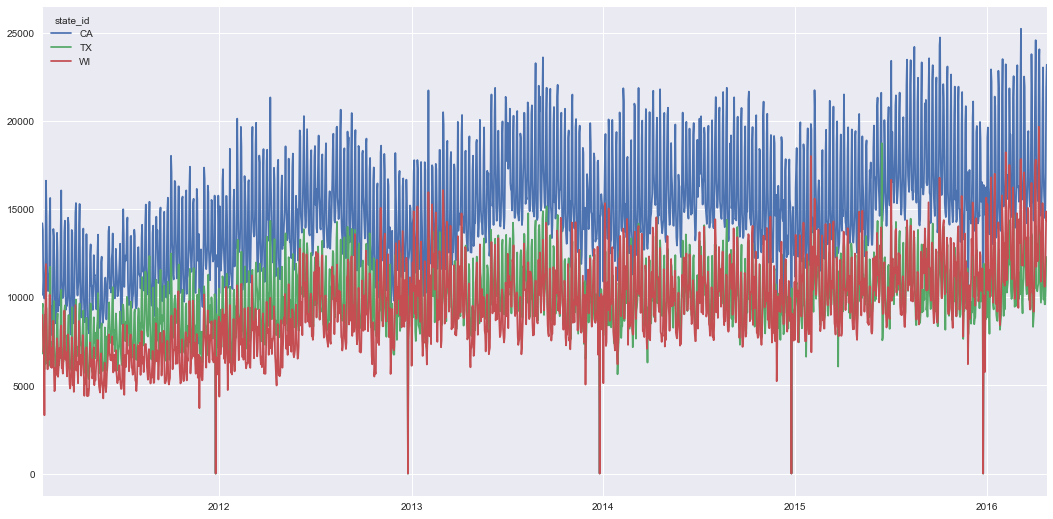

In [21]:
store_agg = sales.drop(['id','item_id','dept_id','store_id','cat_id'],axis=1).groupby('state_id').sum()
store_agg.columns=dates
store_agg.transpose().plot(figsize=(18,9));

# Unit Sales by Dept ID

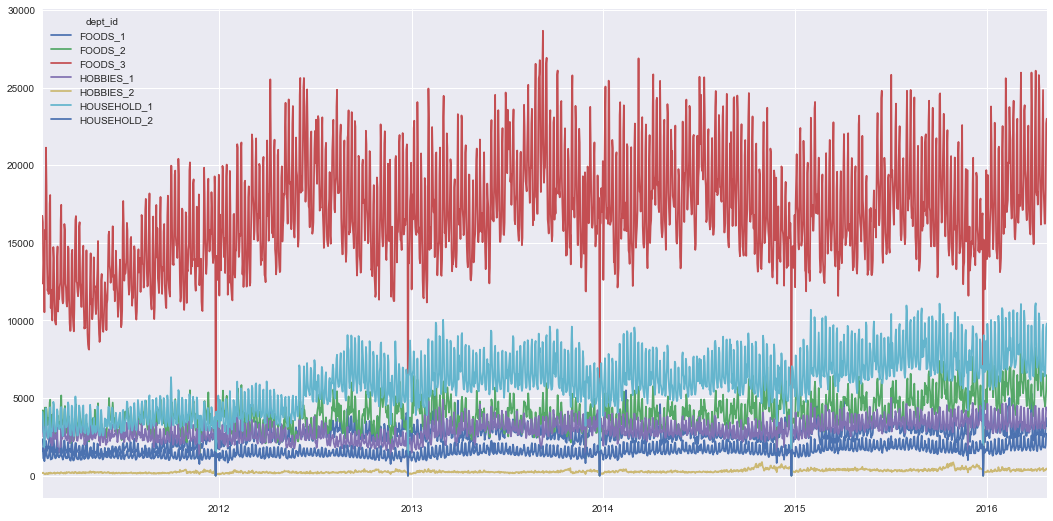

In [22]:

store_agg = sales.drop(['id','item_id','store_id','state_id','cat_id'],axis=1).groupby('dept_id').sum()
store_agg.columns=dates
store_agg.transpose().plot(figsize=(18,9));

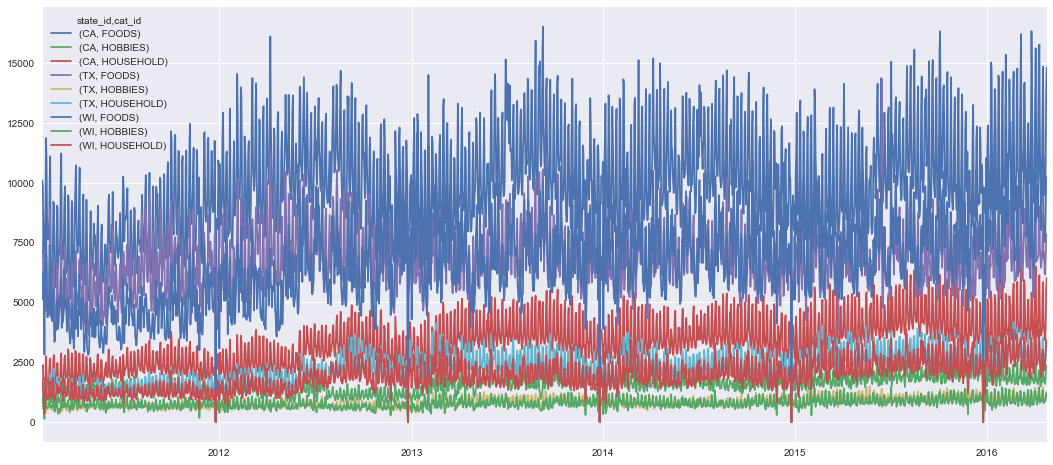

2011-01-29  2011-01-30  2011-01-31  2011-02-01  \
state_id cat_id                                                      
CA       FOODS           10101        9862        6944        7864   
         HOBBIES          1802        1561        1472        1405   
         HOUSEHOLD        2292        2382        1692        1778   
TX       FOODS            6853        7030        5124        5470   
         HOBBIES           879         870         526         809   
         HOUSEHOLD        1706        1730        1128        1102   
WI       FOODS            6224        5866        5106        5544   
         HOBBIES          1083         926         684         455   
         HOUSEHOLD        1691        1522        1107         985   

                    2011-02-02  2011-02-03  2011-02-04  2011-02-05  \
state_id cat_id                                                      
CA       FOODS            7178        8256        9005       11870   
         HOBBIES          1181        1459        1314        1986   
         HOUSEHOLD        1566        1607        1932        2754   
TX       FOODS            4602        7067        4671        7055   
         HOBBIES           501         831         390         785   
         HOUSEHOLD         809        1108        1165        1600   
WI       FOODS            2823        6770        6814        8826   
         HOBBIES           132         930        1240        1215   
         HOUSEHOLD         354        1183        1479        1841   

                    2011-02-06  2011-02-07  2011-02-08  2011-02-09  \
state_id cat_id                                                      
CA       FOODS           10977        8637        7961        7625   
         HOBBIES          1482        1508        1381        1235   
         HOUSEHOLD        2237        1677        1591        1490   
TX       FOODS            6920        5505        4628        5152   
         HOBBIES           794         524         556         618   
         HOUSEHOLD        1662        1290        1040         970   
WI       FOODS            6965        4759        4374        4878   
         HOBBIES           623         583         610         604   
         HOUSEHOLD        1076        1089         930        1086   

                    2011-02-10  2011-02-11  2011-02-12  2011-02-13  \
state_id cat_id                                                      
CA       FOODS            8147        7992       10129       11109   
         HOBBIES          1383        1388        1904        1868   
         HOUSEHOLD        1674        1974        2577        2653   
TX       FOODS            4473        5370        7664        8882   
         HOBBIES           648         598         747         837   
         HOUSEHOLD         988        1234        1670        2006   
WI       FOODS            4720        5676        7394        6665   
         HOBBIES           669         836        1048         712   
         HOUSEHOLD        1054        1377        1700        1648   

                    2011-02-14  2011-02-15  2011-02-16  2011-02-17  \
state_id cat_id                                                      
CA       FOODS            6483        6336        6266        5550   
         HOBBIES          1056        1371         941         810   
         HOUSEHOLD        1505        1789        1637        1475   
TX       FOODS            5125        5711        4771        4523   
         HOBBIES           555         519         589         612   
         HOUSEHOLD        1039        1230        1246        1277   
WI       FOODS            4407        5378        4314        4217   
         HOBBIES           622         664         640         627   
         HOUSEHOLD        1012        1072        1039        1227   

                    2011-02-18  2011-02-19  2011-02-20  2011-02-21  \
state_id cat_id                                                      
CA       FOODS           

In [23]:
store_agg = sales.drop(['id','item_id','store_id','dept_id'],axis=1).groupby(['state_id','cat_id']).sum()
store_agg.columns=dates
store_agg.transpose().plot(figsize=(18,8))
plt.show()
store_agg

# Statewise Category with a rolling mean of 7

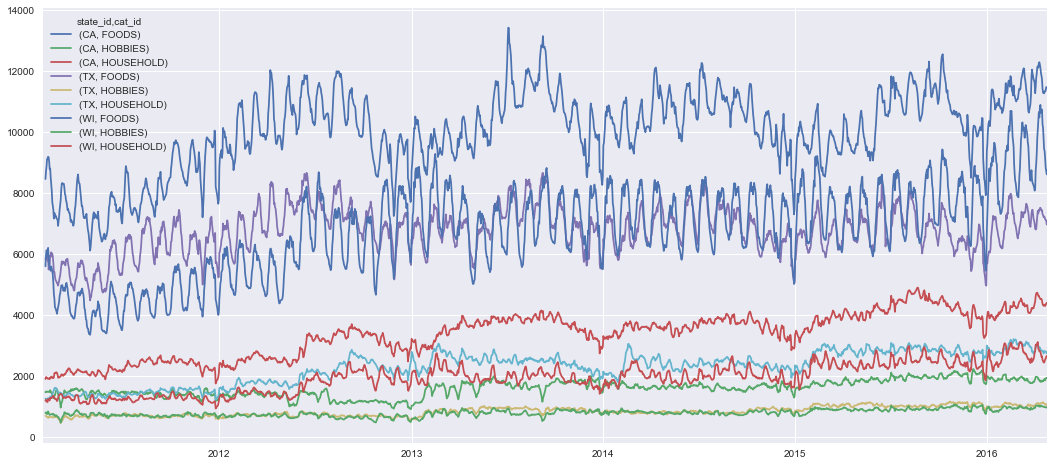

In [24]:
store_agg.transpose().rolling(window=7).mean().plot(figsize=(18,8));

# Price

In [25]:
revenue = data[data['unit_sales']>0]
revenue = revenue.groupby(['date'])['revenue'].sum().reset_index()

print(revenue.shape)
revenue.head()

(1913, 2)


date   revenue
0 2011-01-29  81650.61
1 2011-01-30  78970.57
2 2011-01-31  57706.91
3 2011-02-01  60761.20
4 2011-02-02  46959.95

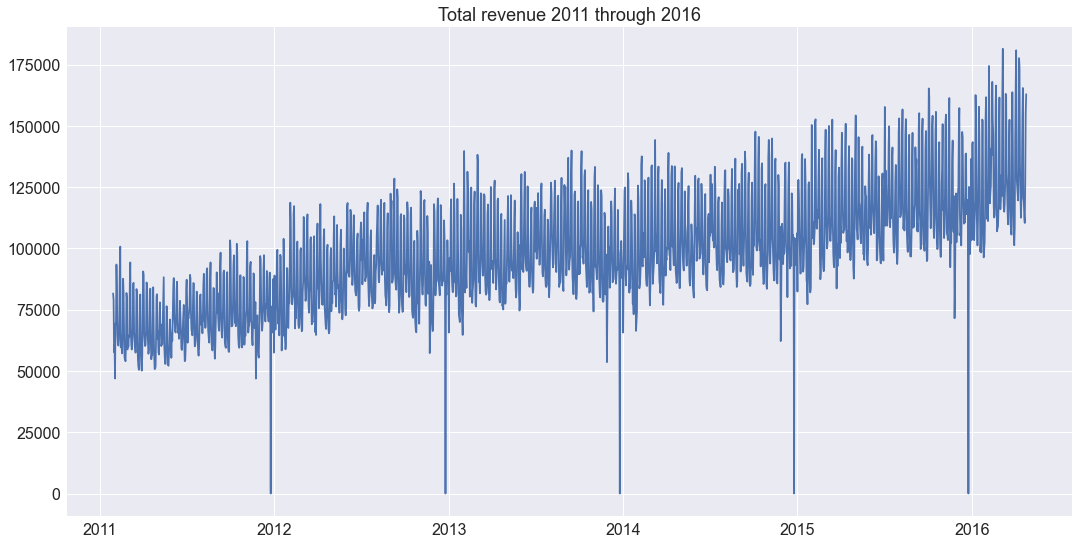

In [26]:


plot_options=get_plot_defaults() # get default options
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,9))
x=revenue['date']
y=revenue['revenue']
ax.plot(x,y)
plot_options.update({'title':'Total revenue 2011 through 2016'})
set_axisparams(plot_options,ax) # set the axis parameters >> nicer than matplotlib defaults



In [27]:
# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
from scipy import stats

d = np.arange(0,len(x))
slope, intercept, r_value, p_value, std_err = stats.linregress(d,y)

# daily average sales growth
print(slope)

29.671435125457315


In [28]:
# Yearly Sales
year_revenue = revenue.copy()
year_revenue['year']=revenue['date'].dt.year
year_revenue = year_revenue.groupby('year')['revenue'].sum().reset_index()
year_revenue.rename({'revenue':'CY_Sales'},axis=1,inplace=True)
year_revenue['PY_Sales']=year_revenue['CY_Sales'].shift(1)
year_revenue['YoY_Sales']=year_revenue['CY_Sales']/year_revenue['PY_Sales'] - 1

display(year_revenue.head(6))



year      CY_Sales      PY_Sales  YoY_Sales
0  2011  2.389134e+07           NaN        NaN
1  2012  3.264920e+07  2.389134e+07   0.366571
2  2013  3.592337e+07  3.264920e+07   0.100283
3  2014  3.786191e+07  3.592337e+07   0.053963
4  2015  4.241646e+07  3.786191e+07   0.120294
5  2016  1.493429e+07  4.241646e+07  -0.647913

In [29]:
# average yearly sales growth ... exclude 2016 since it is a partial year
year_revenue[year_revenue['year']<2016]["YoY_Sales"].mean()

0.1602777140375446

# BI Files
* product_sales_day enables cross indexing of tables in power bi
* add year-month prices and calendar ... better for humans, cross reference, and more general

In [30]:
print('sales', end='')
display(sales.head())
print('\nprices',end='')
display(prices.head())
print('\ncal',end='')
display(cal.head())

sales

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  d_5  d_6  d_7  d_8  d_9  d_10  d_11  d_12  \
0       CA    0    0    0    0    0    0    0    0    0     0     0     0   
1       CA    0    0    0    0    0    0    0    0    0     0     0     0   
2       CA    0    0    0    0    0    0    0    0    0     0     0     0   
3       CA    0    0    0    0    0    0    0    0    0     0     0     0   
4       CA    0    0    0    0    0    0    0    0    0     0     0     0   

   d_13  d_14  d_15  d_16  d_17  d_18  d_19  d_20  d_21  d_22  d_23  d_24  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_25  d_26  d_27  d_28  d_29  d_30  d_31  d_32  d_33  d_34  d_35  d_36  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     0     0     0     0     0     0     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_37  d_38  d_39  d_40  d_41  d_42  d_43  d_44  d_45  d_46  d_47  d_48  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     2     0     0     0     2     0     1     0     0     0     0     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_49  d_50  d_51  d_52  d_53  d_54  d_55  d_56  d_57  d_58  d_59  d_60  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     2     0     1     0     0     1     1     1     0     2     3   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_61  d_62  d_63  d_64  d_65  d_66  d_67  d_68  d_69  d_70  d_71  d_72  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     1     0     0     0     0     0     1     0     0     1     1     0   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_73  d_74  d_75  d_76  d_77  d_78  d_79  d_80  d_81  d_82  d_83  d_84  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   
3     0     1     0     0     1     2     3     0     2     0     0     2   
4     0     0     0     0     0     0     0     0     0     0     0     0   

   d_85  d_86  d_87  d_88  d_89  d_90  d_91  d_92  d_93  d_94  d_95  d_96  \
0     0     0     0     0     0     0     0     0     0     0     0     0   
1     0     0     0     0     0     0     0     0     0     0     0     0   
2     0     0     0     0     0     0     0     0     0     0     0     0   



prices

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26


cal

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

### Dim ItemDeptCat

In [31]:
Dim_ItemDeptCat=sales.groupby(['item_id','dept_id','cat_id'])['store_id'].last().reset_index().drop('store_id',axis=1)
Dim_ItemDeptCat.head()


item_id  dept_id cat_id
0  FOODS_1_001  FOODS_1  FOODS
1  FOODS_1_002  FOODS_1  FOODS
2  FOODS_1_003  FOODS_1  FOODS
3  FOODS_1_004  FOODS_1  FOODS
4  FOODS_1_005  FOODS_1  FOODS

### StoreState

In [32]:
StoreState=sales.groupby(['store_id','state_id'])['item_id'].last().reset_index().drop('item_id',axis=1)

display(StoreState)
StoreState['country']='United States'
StoreState['state']=''

state_ids = list(StoreState['state_id'].values)
print(state_ids)
display(StoreState)
StoreState.set_index('state_id',inplace=True)

for state_id in state_ids:
    if 'CA' in state_id: state='California'
    if 'TX' in state_id: state='Texas'
    if 'WI' in state_id: state='Wisconsin'
    StoreState.loc[state_id]['state']=state
    
StoreState.reset_index(inplace=True)    

StoreState



store_id state_id
0     CA_1       CA
1     CA_2       CA
2     CA_3       CA
3     CA_4       CA
4     TX_1       TX
5     TX_2       TX
6     TX_3       TX
7     WI_1       WI
8     WI_2       WI
9     WI_3       WI

['CA', 'CA', 'CA', 'CA', 'TX', 'TX', 'TX', 'WI', 'WI', 'WI']


store_id state_id        country state
0     CA_1       CA  United States      
1     CA_2       CA  United States      
2     CA_3       CA  United States      
3     CA_4       CA  United States      
4     TX_1       TX  United States      
5     TX_2       TX  United States      
6     TX_3       TX  United States      
7     WI_1       WI  United States      
8     WI_2       WI  United States      
9     WI_3       WI  United States

state_id store_id        country       state
0       CA     CA_1  United States  California
1       CA     CA_2  United States  California
2       CA     CA_3  United States  California
3       CA     CA_4  United States  California
4       TX     TX_1  United States       Texas
5       TX     TX_2  United States       Texas
6       TX     TX_3  United States       Texas
7       WI     WI_1  United States   Wisconsin
8       WI     WI_2  United States   Wisconsin
9       WI     WI_3  United States   Wisconsin

### Cal_Events

In [33]:
display(cal.head())
print(cal.columns)

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

Index(['date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'd',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2',
       'snap_CA', 'snap_TX', 'snap_WI'],
      dtype='object')


In [34]:
# Events can seem a little inconsistent
# ... Easter only for year 2014-04-08 and categorized under Cultural
# ... actually entered as OrthodoxEaster, a little strange and inconsistent but okay, we'll take it as is


cal[cal['event_name_1'].notnull()].head(20)

date  wm_yr_wk    weekday  wday  month  year      d  \
8    2011-02-06     11102     Sunday     2      2  2011    d_9   
16   2011-02-14     11103     Monday     3      2  2011   d_17   
23   2011-02-21     11104     Monday     3      2  2011   d_24   
39   2011-03-09     11106  Wednesday     5      3  2011   d_40   
46   2011-03-16     11107  Wednesday     5      3  2011   d_47   
47   2011-03-17     11107   Thursday     6      3  2011   d_48   
50   2011-03-20     11108     Sunday     2      3  2011   d_51   
85   2011-04-24     11113     Sunday     2      4  2011   d_86   
87   2011-04-26     11113    Tuesday     4      4  2011   d_88   
96   2011-05-05     11114   Thursday     6      5  2011   d_97   
99   2011-05-08     11115     Sunday     2      5  2011  d_100   
121  2011-05-30     11118     Monday     3      5  2011  d_122   
122  2011-05-31     11118    Tuesday     4      5  2011  d_123   
134  2011-06-12     11120     Sunday     2      6  2011  d_135   
141  2011-06-19     11121     Sunday     2      6  2011  d_142   
156  2011-07-04     11123     Monday     3      7  2011  d_157   
184  2011-08-01     11127     Monday     3      8  2011  d_185   
214  2011-08-31     11131  Wednesday     5      8  2011  d_215   
219  2011-09-05     11132     Monday     3      9  2011  d_220   
254  2011-10-10     11137     Monday     3     10  2011  d_255   

        event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  \
8          SuperBowl     Sporting          NaN          NaN        1        1   
16     ValentinesDay     Cultural          NaN          NaN        0        0   
23     PresidentsDay     National          NaN          NaN        0        0   
39         LentStart    Religious          NaN          NaN        1        1   
46         LentWeek2    Religious          NaN          NaN        0        0   
47     StPatricksDay     Cultural          NaN          NaN        0        0   
50         Purim End    Religious          NaN          NaN        0        0   
85    OrthodoxEaster    Religious       Easter     Cultural        0        0   
87        Pesach End    Religious          NaN          NaN        0        0   
96     Cinco De Mayo     Cultural          NaN          NaN        1        1   
99      Mother's day     Cultural          NaN          NaN        1        0   
121      MemorialDay     National          NaN          NaN        0        0   
122   NBAFinalsStart     Sporting          NaN          NaN        0        0   
134     NBAFinalsEnd     Sporting          NaN          NaN        0        1   
141     Father's day     Cultural          NaN          NaN        0        0   
156  IndependenceDay     National          NaN          NaN        1        0   
184   Ramadan starts    Religious          NaN          NaN        1        1   
214      Eid al-Fitr    Religious          NaN          NaN        0        0   
219         LaborDay     National          NaN          NaN        1        1   
254      ColumbusDay     National          NaN          NaN        1        0   

     snap_WI  
8          1  
16         1  
23         0  
39         1  
46         0  
47         0  
50         0  
85         0  
87         0  
96         1  
99         1  
121        0  
122        0  
134        1  
141        0  
156        0  
184        0  
214        0  
219        1  
254        0

In [35]:
# Store Calender For Each Store
# Cal Events unstacked for each category (Cultural_1,2, Religious_1,2, etc ...) 

stores = list(sales.groupby('store_id')['store_id'].last().index)
states = list(sales.groupby('state_id')['state_id'].last().index)


event_types_1 = list(cal.groupby('event_type_1')['event_type_1'].last().index)
event_types_2 = list(cal.groupby('event_type_2')['event_type_2'].last().index)
event_types=list (set(event_types_1) | set(event_types_2) ) # union, creates unique set of items across both sets, no duplicates

print(f'event_types = {event_types}')


# create the basic cal_tmp ... will be replicated for each storeid
cols=['date','event_name_1','event_type_1','event_name_2','event_type_2','snap_CA','snap_TX','snap_WI']
cal_tmp = cal[cols].copy()


cal_tmp['store_id']=''
cal_tmp['state']=''
cal_tmp['snap']=0

# add empty event type cols

#for et in event_types:
#    cal_tmp[et]=0
#    cal_tmp[et+'_event_name']=''

    
# create event type columns
#for et in event_types:
#    cal_tmp[et+'_1']=0 # initialize column to zero
#    cal_tmp[et+'_name_1'] = ''
#    cal_tmp[et+'_2']=0 # initialize column to zero    
#    cal_tmp[et+'_name_2'] = ''
    
# cast event_type to str since categorical type messes up string compare
cal_tmp['event_type_1']=cal_tmp['event_type_1'].astype(str)  # str compare below messes up with categorical types
cal_tmp['event_type_2']=cal_tmp['event_type_2'].astype(str)  # str compare below messes up with categorical types

 
print('cal_tmp.head()')
display(cal_tmp.head())


state_dict = {'CA':'California', 'TX':'Texas', 'WI': 'Wisconsin'}
#stores=['CA_1']
#### Store Calendar
cal_events = pd.DataFrame()
for store in stores:
    
    cal_tmp2 = cal_tmp.copy()
    state_id = store[:2]
    state = state_dict[state_id] 
    snap = 'snap_'+state_id
    
    cal_tmp2['state']=state
    cal_tmp2['store_id']=store
    
    for et in event_types:
        
        # event 1
        cal_tmp2[et +'_1']=cal_tmp2['event_type_1'].apply(lambda x: 1 if x == et else 0)
        cal_tmp2[et +'_name_1']=cal_tmp2.apply(lambda row: row['event_name_1'] if row['event_type_1'] == et else '', axis=1)
        
        # events 2
        cal_tmp2[et +'_2']=cal_tmp2['event_type_2'].apply(lambda x: 1 if x == et else 0)
        cal_tmp2[et +'_name_2']=cal_tmp2.apply(lambda row: row['event_name_2'] if row['event_type_2'] == et else '', axis=1)
    
    cal_tmp2['snap']=cal_tmp2[snap]
    
    cal_events=cal_events.append(cal_tmp2,sort=False)
    cal_events.drop(['snap_CA','snap_TX','snap_WI','event_type_1','event_type_2','event_name_1','event_name_2'], axis=1, inplace=True) 
    cal_events.reset_index()


#for et in event_types:
#    cal_events[et]=cal_events[et+'_1'] + cal_events[et+'et_2']

cal_events.head()



event_types = ['Religious', 'National', 'Cultural', 'Sporting']
cal_tmp.head()


date event_name_1 event_type_1 event_name_2 event_type_2  snap_CA  \
0  2011-01-29          NaN          nan          NaN          nan        0   
1  2011-01-30          NaN          nan          NaN          nan        0   
2  2011-01-31          NaN          nan          NaN          nan        0   
3  2011-02-01          NaN          nan          NaN          nan        1   
4  2011-02-02          NaN          nan          NaN          nan        1   

   snap_TX  snap_WI store_id state  snap  
0        0        0                    0  
1        0        0                    0  
2        0        0                    0  
3        1        0                    0  
4        0        1                    0

date store_id       state  snap  Religious_1 Religious_name_1  \
0  2011-01-29     CA_1  California     0            0                    
1  2011-01-30     CA_1  California     0            0                    
2  2011-01-31     CA_1  California     0            0                    
3  2011-02-01     CA_1  California     1            0                    
4  2011-02-02     CA_1  California     1            0                    

   Religious_2 Religious_name_2  National_1 National_name_1  National_2  \
0            0                            0                           0   
1            0                            0                           0   
2            0                            0                           0   
3            0                            0                           0   
4            0                            0                           0   

  National_name_2  Cultural_1 Cultural_name_1  Cultural_2 Cultural_name_2  \
0                           0                           0                   
1                           0                           0                   
2                           0                           0                   
3                           0                           0                   
4                           0                           0                   

   Sporting_1 Sporting_name_1  Sporting_2 Sporting_name_2  
0           0                           0                  
1           0                           0                  
2           0                           0                  
3           0                           0                  
4           0                           0

In [36]:
cal_events[cal_events['Religious_1']!=0].head()

date store_id       state  snap  Religious_1 Religious_name_1  \
39  2011-03-09     CA_1  California     1            1        LentStart   
46  2011-03-16     CA_1  California     0            1        LentWeek2   
50  2011-03-20     CA_1  California     0            1        Purim End   
85  2011-04-24     CA_1  California     0            1   OrthodoxEaster   
87  2011-04-26     CA_1  California     0            1       Pesach End   

    Religious_2 Religious_name_2  National_1 National_name_1  National_2  \
39            0                            0                           0   
46            0                            0                           0   
50            0                            0                           0   
85            0                            0                           0   
87            0                            0                           0   

   National_name_2  Cultural_1 Cultural_name_1  Cultural_2 Cultural_name_2  \
39                           0                           0                   
46                           0                           0                   
50                           0                           0                   
85                           0                           1          Easter   
87                           0                           0                   

    Sporting_1 Sporting_name_1  Sporting_2 Sporting_name_2  
39           0                           0                  
46           0                           0                  
50           0                           0                  
85           0                           0                  
87           0                           0

In [37]:
# Cal Events Stacked events into one column ... previously they are unstacked

stores = list(sales.groupby('store_id')['store_id'].last().index)
states = list(sales.groupby('state_id')['state_id'].last().index)
state_dict = {'CA':'California', 'TX':'Texas', 'WI': 'Wisconsin'}

# event 1
print('events 1 ...')
cols = ['date','event_name_1','event_type_1']
df_tmp = cal[cols].copy().rename({'event_name_1':'event_name','event_type_1':'event_type'},axis=1)
df_tmp['state'] = ''
df_tmp['store_id'] = ''
df_tmp.dropna(how='any', axis=0,inplace=True)
print(df_tmp.shape)
display(df_tmp.head())

cal_events_detail=pd.DataFrame()
for store in stores:
    state_id = store[:2]
    df_tmp['state']=state_dict[state_id]
    df_tmp['store_id']=store

    cal_events_detail=cal_events_detail.append(df_tmp)
print(f'cal_cvents_detail.shape = {cal_events_detail.shape}')  

# events 2
print('events 2 ...')
cols = ['date','event_name_2','event_type_2']
df_tmp = cal[cols].copy().rename({'event_name_2':'event_name','event_type_2':'event_type'},axis=1)
df_tmp['state'] = ''
df_tmp['store_id'] = ''
df_tmp.dropna(how='any', axis=0,inplace=True)
print(df_tmp.shape)
for store in stores:
    state_id = store[:2]
    df_tmp['state']=state_dict[state_id]
    df_tmp['store_id']=store
    cal_events_eetail=cal_events_detail.append(df_tmp)

print(f'cal_events_detail.shape = {cal_events_detail.shape}') 



print('snap')
df_tmp = cal[['date','snap_CA','snap_TX','snap_WI']].copy()
df_tmp['store_id']=''
df_tmp['state']=''

for store in stores:  
    state_id = store[:2]
    snap = 'snap_'+state_id
    df_tmp2 = df_tmp[['date','store_id','state',snap]]
    df_tmp2 = df_tmp2[df_tmp2[snap]!=0].copy()
    
    df_tmp2['state']=state_dict[state_id]
    df_tmp2['store_id']=store

    print(snap)

   
    df_tmp2.rename({snap:'event_name'},axis=1,inplace=True)
    df_tmp2['event_name']='SNAP'
    df_tmp2['event_type']='SNAP'
    cal_events_detail = cal_events_detail.append(df_tmp2, sort=False)
 
    
# SNAP
print(f'cal_events_detail.shape = {cal_events_detail.shape}') 
print('cal_events_detail')
cal_events_detail.head()


events 1 ...
(162, 5)


date     event_name event_type state store_id
8   2011-02-06      SuperBowl   Sporting               
16  2011-02-14  ValentinesDay   Cultural               
23  2011-02-21  PresidentsDay   National               
39  2011-03-09      LentStart  Religious               
46  2011-03-16      LentWeek2  Religious

cal_cvents_detail.shape = (1620, 5)
events 2 ...
(5, 5)
cal_events_detail.shape = (1620, 5)
snap
snap_CA
snap_CA
snap_CA
snap_CA
snap_TX
snap_TX
snap_TX
snap_WI
snap_WI
snap_WI
cal_events_detail.shape = (8120, 5)
cal_events_detail


date     event_name event_type       state store_id
8   2011-02-06      SuperBowl   Sporting  California     CA_1
16  2011-02-14  ValentinesDay   Cultural  California     CA_1
23  2011-02-21  PresidentsDay   National  California     CA_1
39  2011-03-09      LentStart  Religious  California     CA_1
46  2011-03-16      LentWeek2  Religious  California     CA_1

In [38]:
# Event Summary

cal_events_summary=cal_events_detail.groupby(['date','state' ,'store_id' ,'event_type'])['event_type'].count()

cal_events_summary=pd.DataFrame(cal_events_summary)
cal_events_summary.rename({'event_type':'event_type_count'},axis=1,inplace=True)
cal_events_summary=cal_events_summary.unstack()
cal_events_summary.columns=[ x[1] for x in cal_events_summary.columns ]
cal_events_summary = cal_events_summary.fillna(0)
cal_events_summary = cal_events_summary.reset_index()
cal_events_summary.head()


date       state store_id  Cultural  National  Religious  SNAP  \
0  2011-02-01  California     CA_1       0.0       0.0        0.0   1.0   
1  2011-02-01  California     CA_2       0.0       0.0        0.0   1.0   
2  2011-02-01  California     CA_3       0.0       0.0        0.0   1.0   
3  2011-02-01  California     CA_4       0.0       0.0        0.0   1.0   
4  2011-02-01       Texas     TX_1       0.0       0.0        0.0   1.0   

   Sporting  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0

### Weekly_Prices

* create DIM_Prices from the merged data frame. 
* this will create NAs for weeks where there is a price missing ... this is good 
* fill NA with first foward then back fill not mean so as to fill a recent price not mean over a long period

In [39]:
display(prices.head())
prices[~prices['sell_price'].isnull()].shape

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

(6841121, 4)

In [46]:
display(data.head(50))

id        item_id    dept_id   cat_id store_id  \
0   HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1   HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2   HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3   HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4   HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   
5   HOBBIES_1_006_CA_1_validation  HOBBIES_1_006  HOBBIES_1  HOBBIES     CA_1   
6   HOBBIES_1_007_CA_1_validation  HOBBIES_1_007  HOBBIES_1  HOBBIES     CA_1   
7   HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES     CA_1   
8   HOBBIES_1_009_CA_1_validation  HOBBIES_1_009  HOBBIES_1  HOBBIES     CA_1   
9   HOBBIES_1_010_CA_1_validation  HOBBIES_1_010  HOBBIES_1  HOBBIES     CA_1   
10  HOBBIES_1_011_CA_1_validation  HOBBIES_1_011  HOBBIES_1  HOBBIES     CA_1   
11  HOBBIES_1_012_CA_1_validation  HOBBIES_1_012  HOBBIES_1  HOBBIES     CA_1   
12  HOBBIES_1_013_CA_1_validation  HOBBIES_1_013  HOBBIES_1  HOBBIES     CA_1   
13  HOBBIES_1_014_CA_1_validation  HOBBIES_1_014  HOBBIES_1  HOBBIES     CA_1   
14  HOBBIES_1_015_CA_1_validation  HOBBIES_1_015  HOBBIES_1  HOBBIES     CA_1   
15  HOBBIES_1_016_CA_1_validation  HOBBIES_1_016  HOBBIES_1  HOBBIES     CA_1   
16  HOBBIES_1_017_CA_1_validation  HOBBIES_1_017  HOBBIES_1  HOBBIES     CA_1   
17  HOBBIES_1_018_CA_1_validation  HOBBIES_1_018  HOBBIES_1  HOBBIES     CA_1   
18  HOBBIES_1_019_CA_1_validation  HOBBIES_1_019  HOBBIES_1  HOBBIES     CA_1   
19  HOBBIES_1_020_CA_1_validation  HOBBIES_1_020  HOBBIES_1  HOBBIES     CA_1   
20  HOBBIES_1_021_CA_1_validation  HOBBIES_1_021  HOBBIES_1  HOBBIES     CA_1   
21  HOBBIES_1_022_CA_1_validation  HOBBIES_1_022  HOBBIES_1  HOBBIES     CA_1   
22  HOBBIES_1_023_CA_1_validation  HOBBIES_1_023  HOBBIES_1  HOBBIES     CA_1   
23  HOBBIES_1_024_CA_1_validation  HOBBIES_1_024  HOBBIES_1  HOBBIES     CA_1   
24  HOBBIES_1_025_CA_1_validation  HOBBIES_1_025  HOBBIES_1  HOBBIES     CA_1   
25  HOBBIES_1_026_CA_1_validation  HOBBIES_1_026  HOBBIES_1  HOBBIES     CA_1   
26  HOBBIES_1_027_CA_1_validation  HOBBIES_1_027  HOBBIES_1  HOBBIES     CA_1   
27  HOBBIES_1_028_CA_1_validation  HOBBIES_1_028  HOBBIES_1  HOBBIES     CA_1   
28  HOBBIES_1_029_CA_1_validation  HOBBIES_1_029  HOBBIES_1  HOBBIES     CA_1   
29  HOBBIES_1_030_CA_1_validation  HOBBIES_1_030  HOBBIES_1  HOBBIES     CA_1   
30  HOBBIES_1_031_CA_1_validation  HOBBIES_1_031  HOBBIES_1  HOBBIES     CA_1   
31  HOBBIES_1_032_CA_1_validation  HOBBIES_1_032  HOBBIES_1  HOBBIES     CA_1   
32  HOBBIES_1_033_CA_1_validation  HOBBIES_1_033  HOBBIES_1  HOBBIES     CA_1   
33  HOBBIES_1_034_CA_1_validation  HOBBIES_1_034  HOBBIES_1  HOBBIES     CA_1   
34  HOBBIES_1_035_CA_1_validation  HOBBIES_1_035  HOBBIES_1  HOBBIES     CA_1   
35  HOBBIES_1_036_CA_1_validation  HOBBIES_1_036  HOBBIES_1  HOBBIES     CA_1   
36  HOBBIES_1_037_CA_1_validation  HOBBIES_1_037  HOBBIES_1  HOBBIES     CA_1   
37  HOBBIES_1_038_CA_1_validation  HOBBIES_1_038  HOBBIES_1  HOBBIES     CA_1   
38  HOBBIES_1_039_CA_1_validation  HOBBIES_1_039  HOBBIES_1  HOBBIES     CA_1   
39  HOBBIES_1_040_CA_1_validation  HOBBIES_1_040  HOBBIES_1  HOBBIES     CA_1   
40  HOBBIES_1_041_CA_1_validation  HOBBIES_1_041  HOBBIES_1  HOBBIES     CA_1   
41  HOBBIES_1_042_CA_1_validation  HOBBIES_1_042  HOBBIES_1  HOBBIES     CA_1   
42  HOBBIES_1_043_CA_1_validation  HOBBIES_1_043  HOBBIES_1  HOBBIES     CA_1   
43  HOBBIES_1_044_CA_1_validation  HOBBIES_1_044  HOBBIES_1  HOBBIES     CA_1   
44  HOBBIES_1_045_CA_1_validation  HOBBIES_1_045  HOBBIES_1  HOBBIES     CA_1   
45  HOBBIES_1_046_CA_1_validation  HOBBIES_1_046  HOBBIES_1  HOBBIES     CA_1   
46  HOBBIES_1_047_CA_1_validation  HOBBIES_1_047  HOBBIES_1  HOBBIES     CA_1   
47  HOBBIES_1_048_CA_1_validation  HOBBIES_1_048  HOBBIES_1  HOBBIES     CA_1   
48  HOBBIES_1_049_CA_1_validation  HOBBIES_1_049  HOBBIES_1  H

In [50]:
# Dim_Prices ...
#  fillna sell_price in an attempt to still capture revenue when sell_price for the week is na
cols = ['yearweek', 'date',  'store_id','item_id','sell_price']

Prices_date = data[cols].groupby(['date','store_id','item_id'])['sell_price'].last().reset_index() # note, multi-index series
display(Prices_date.head())
display(Prices_date[Prices_date.isnull().any(axis=1)].head()) # note there are some sell_price nulls

# https://stackoverflow.com/questions/46391128/pandas-fillna-using-groupby
# ffill then bfill to get fill initial missing and then last missing ... this should be more accurate than mean fill
print('fillna Week_Prices ...')
Prices_date['sell_price'] = Prices_date['sell_price'].astype('float')
Prices_date['sell_price'] = Prices_date.groupby(['store_id','item_id'])['sell_price'].apply(lambda x: x.ffill().bfill())  # filll null sell_price 





date store_id      item_id  sell_price
0 2011-01-29     CA_1  FOODS_1_001        2.00
1 2011-01-29     CA_1  FOODS_1_002        7.88
2 2011-01-29     CA_1  FOODS_1_003        2.88
3 2011-01-29     CA_1  FOODS_1_004         NaN
4 2011-01-29     CA_1  FOODS_1_005        2.94

date store_id      item_id  sell_price
3  2011-01-29     CA_1  FOODS_1_004         NaN
6  2011-01-29     CA_1  FOODS_1_008         NaN
7  2011-01-29     CA_1  FOODS_1_009         NaN
8  2011-01-29     CA_1  FOODS_1_010         NaN
10 2011-01-29     CA_1  FOODS_1_012         NaN

fillna Week_Prices ...


In [52]:
Prices_date.shape

(58327370, 4)

In [40]:
# Week Prices ...  Dim_Prices ...
#  fillna sell_price in an attempt to still capture revenue when sell_price for the week is na
cols = ['yearweek','store_id','item_id','sell_price']

Week_Prices = data[cols].groupby(['yearweek','store_id','item_id'])['sell_price'].last().reset_index() # note, multi-index series
display(Week_Prices.head())
display(Week_Prices[Week_Prices.isnull().any(axis=1)].head()) # note there are some sell_price nulls
# https://stackoverflow.com/questions/46391128/pandas-fillna-using-groupby
# ffill then bfill to get fill initial missing and then last missing ... this should be more accurate than mean fill
print('fillna Week_Prices ...')
Week_Prices['sell_price']=Week_Prices['sell_price'].astype('float')
Week_Prices['sell_price'] = Week_Prices.groupby(['store_id','item_id'])['sell_price'].apply(lambda x: x.ffill().bfill())  # filll null sell_price 


print('\nWeek_Prices NA')
display(Week_Prices[Week_Prices.isnull().any(axis=1)].head())

print('\nWeek_Prices')
print(f'Week_Prices.shape = {Week_Prices.shape}')
Week_Prices.head()

yearweek store_id      item_id  sell_price
0    201104     CA_1  FOODS_1_001        2.00
1    201104     CA_1  FOODS_1_002        7.88
2    201104     CA_1  FOODS_1_003        2.88
3    201104     CA_1  FOODS_1_004         NaN
4    201104     CA_1  FOODS_1_005        2.94

yearweek store_id      item_id  sell_price
3     201104     CA_1  FOODS_1_004         NaN
6     201104     CA_1  FOODS_1_008         NaN
7     201104     CA_1  FOODS_1_009         NaN
8     201104     CA_1  FOODS_1_010         NaN
10    201104     CA_1  FOODS_1_012         NaN

fillna Week_Prices ...

Week_Prices NA


Empty DataFrame
Columns: [yearweek, store_id, item_id, sell_price]
Index: []


Week_Prices
Week_Prices.shape = (8384750, 4)


yearweek store_id      item_id  sell_price
0    201104     CA_1  FOODS_1_001        2.00
1    201104     CA_1  FOODS_1_002        7.88
2    201104     CA_1  FOODS_1_003        2.88
3    201104     CA_1  FOODS_1_004        1.78
4    201104     CA_1  FOODS_1_005        2.94

### Sales Revenue

In [1]:

# first tranform date columns to dates
print('date columns ...')
cols = sales.columns
Sales = sales.copy()
dates = [d for d in pd.date_range(start = '2011-01-29', end = '2016-04-24')]
Sales.columns = ['id', 'item_id', 'dept_id', 'cat_id','store_id','state_id']+dates
print(Sales.shape)
display(Sales.head())


# melt/pivot the date columns to rows 
print('melt/pivot sales ... ')
Sales = pd.melt(Sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='date', value_name='units')
Sales = Sales[Sales['units']>0] # eliminate zero entries or this will be huge ... 58 mil rows vs 18 mil rows
print(Sales.shape)
display(Sales.head())


# yearweek
print('yearweek ...')
Sales['yearweek']= Sales['date'].dt.year*100+Sales['date'].dt.week
display(Sales.head())


# merge w prices and calculate revenue
print('marge with prices ...')
Sales = pd.merge(Sales, Week_Prices, on=['store_id','item_id','yearweek'], how='left')
Sales.rename({'sell_price':'price'},axis=1, inplace=True)
Sales['revenue']=Sales['units']*Sales['price']
display(data.head())



# Drop non fact columns
print('drop non Fact columns')
drop_cols = ['id', 'dept_id', 'cat_id','state_id']
Sales.drop(drop_cols,axis=1,inplace=True)
print(Sales.shape)
display(Sales.head())


date columns ...


NameError: name 'sales' is not defined

# SAVE BI Files

In [50]:
# Dim_ItemDeptCat
Dim_ItemDeptCat.to_csv(f'{data_path}/ItemDeptCat.csv', index=False)

In [51]:
# Dim_StoreState
StoreState.to_csv(f'{data_path}/StoreState.csv', index=False)

In [52]:
# Fact_Sales
Sales.to_csv(f'{data_path}/Sales.csv', index=False)  # 500 MB ... fyi one wide file is > 8 GB

In [53]:
# event_cal
cal_events_detail.to_csv(f'{data_path}/cal_events_detail.csv', index=False)
cal_events_summary.to_csv(f'{data_path}/cal_events_summary.csv', index=False)

In [54]:
# product_sell_price
Week_Prices.to_csv(f'{data_path}/Week_Prices.csv', index=False)

In [55]:
# assume one item each and create an sell price
#data["sell_price"].fillna(data.groupby(["id","yearweek"])["sell_price"].transform("mean"), inplace=True)
#data['d'] = data['d'].apply(lambda a: a.split('_')[1]).astype(np.int16)
#data.drop(columns=["date","weekday"], inplace=True)
#data.head()

BI Files

* ItemDeptCat.csv
* StoreState.csv
* Sales.csv
* cal_events_detail.csv
* cal_events_summar.csv



